# Application of trained ZS-AMBER to a new task

## Reload a trained ZS-AMBER

In [1]:
%cd /mnt/home/zzhang/workspace/src/AMBER-ZeroShot/examples
%run zero_shot_nas.real_deepsea.py

/mnt/home/zzhang/workspace/src/AMBER-ZeroShot/examples


Using TensorFlow backend.


In [2]:
import sys
arg_str = """foo 
--train-file data/zero_shot_deepsea/train.h5 
--val-file data/zero_shot_deepsea/val.h5 
--model-space long_and_dilation 
--ppo
--wd outputs/new_20200919/test_feats/zs_amber/
--config-file data/zero_shot_deepsea/test_feats.representative_4.config_file.tsv
--dfeature-name-file data/zero_shot_deepsea/dfeatures_ordered_list.txt
"""

arg_list = arg_str.split()
sys.argv = arg_list

# fake arg parsing
parser = argparse.ArgumentParser(description="experimental zero-shot nas")
parser.add_argument("--train-file", type=str, required=True, help="Path to the hdf5 file of training data.")
parser.add_argument("--val-file", type=str, required=True, help="Path to the hdf5 file of validation data.")
parser.add_argument("--model-space", default="simple", choices=['simple', 'long', 'long_and_dilation'], help="Model space choice")
parser.add_argument("--ppo", default=False, action="store_true", help="Use PPO instead of REINFORCE")
parser.add_argument("--wd", type=str, default="./outputs/zero_shot/", help="working dir")
parser.add_argument("--resume", default=False, action="store_true", help="resume previous run")
parser.add_argument("--config-file", type=str, required=True, help="Path to the config file to use.")
parser.add_argument("--dfeature-name-file", type=str, required=True, help="Path to file with dataset feature names listed one per line.")
parser.add_argument("--lockstep-sampling", default=False, action="store_true", help="Ensure same training samples used for all models.")

arg = parser.parse_args()
print(arg)

Namespace(config_file='data/zero_shot_deepsea/test_feats.representative_4.config_file.tsv', dfeature_name_file='data/zero_shot_deepsea/dfeatures_ordered_list.txt', lockstep_sampling=False, model_space='long_and_dilation', ppo=True, resume=False, train_file='data/zero_shot_deepsea/train.h5', val_file='data/zero_shot_deepsea/val.h5', wd='outputs/new_20200919/test_feats/zs_amber/')


In [3]:
configs, config_keys, controller, model_space = read_configs(arg, is_training=False)

{3: 0, 4: 1, 5: 2, 6: 0, 8: 2}


/mnt/home/zzhang/workspace/src/AMBER-ZeroShot/amber/architect/_general_controller.py:541: UserWarning: 
 [<tf.Variable 'controller/create_weights/g_emb:0' shape=(1, 128) dtype=float32_ref>, <tf.Variable 'controller/create_weights/emb/layer_9/w_start:0' shape=(3, 128) dtype=float32_ref>]
  optim_algo=self.optim_algo


In [4]:
#print(configs)

In [5]:
# get random 4 testing features
test_feats = [
    'FEAT480',  # "YY1"   "H1-hESC"
    'FEAT282',  # "DNase" "WI-38"
    'FEAT304',  # "Pol2"  "A549"
    'FEAT144'   # "H3k4me3" "NHLF"
]
configs = {k:configs[k] for k in configs if configs[k]['feat_name'] in test_feats}
print(configs.keys())

dict_keys([0, 1, 2, 3])


In [6]:
controller.load_weights("outputs/new_20200919/long_and_dilation.ppo.0/controller_weights.h5")
for k in configs:
    print(configs[k]['feat_name'])
    a, p = controller.get_action(np.expand_dims(configs[k]['dfeatures'],0))
    print(a); print(p)
    print('-'*10)

/mnt/home/zzhang/workspace/programs/anaconda3/envs/amber-zh/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


FEAT480
[3 0 2 6 1 2 6 0 2 0]
[array([[8.0534242e-12, 4.3316533e-09, 8.5733082e-10, 1.0000000e+00,
        8.2404439e-12, 5.5461019e-10, 6.4222593e-11]], dtype=float32), array([[1.0000000e+00, 1.1177606e-13]], dtype=float32), array([[1.3930006e-13, 2.8718092e-13, 1.0000000e+00]], dtype=float32), array([[7.0824450e-14, 7.6637474e-11, 9.5581338e-12, 9.5180344e-09,
        2.3586165e-13, 3.2427332e-11, 1.0000000e+00]], dtype=float32), array([[5.3825455e-10, 1.0000000e+00]], dtype=float32), array([[5.3258975e-14, 1.0959014e-12, 1.0000000e+00]], dtype=float32), array([[2.8883767e-17, 2.0327639e-15, 2.3332895e-14, 2.3591358e-15,
        6.0238449e-17, 5.9949014e-14, 1.0000000e+00]], dtype=float32), array([[1.0000000e+00, 1.4743487e-18, 2.2894671e-16, 1.0035300e-17]],
      dtype=float32), array([[7.282041e-14, 9.567595e-13, 1.000000e+00]], dtype=float32), array([[1.0000000e+00, 3.4371446e-17, 6.5259918e-16]], dtype=float32)]
----------
FEAT282
[3 1 0 6 1 2 6 0 2 0]
[array([[1.1649705e-13, 3.

In [7]:
n_rep = 10
# full data is 4.4m with pos+neg strands
full_training_patience = 40
zs_res = {}

global_manager_trial_cnt = {k:0 for k in configs}
global_manager_record = pd.DataFrame(columns=['manager', 'feat_name', 'amber', 'step', 'arc', 'reward'])

for k in configs:
    feat_name = configs[k]['feat_name']
    print('-'*10); print(feat_name); print('-'*10)
    res_list = []
    manager = configs[k]['manager']
    manager._earlystop_patience = full_training_patience
    manager.verbose=0
    for i in range(n_rep):
        arc, prob = controller.get_action(np.expand_dims(configs[k]['dfeatures'],0))
        reward, _ = manager.get_rewards(trial=global_manager_trial_cnt[k], model_arc=arc)
        global_manager_trial_cnt[k] += 1
        print(reward)
        res_list.append(reward)
        global_manager_record = global_manager_record.append({
            'manager': k, 
            'feat_name': feat_name, 
            'amber': 'zs', 
            'step': i,
            'arc': ','.join([str(a) for a in arc]),
            'reward': reward
        }, ignore_index=True)
    zs_res[k] = res_list

----------
FEAT480
----------


[1546964][20:22:47] Preprocessing..  0.809 sec
[1546964][20:22:48] Trial 0: Start training model..  632.368 sec
[1546964] Postprocessing..WARNING: Logging before flag parsing goes to stderr.
W1001 20:33:21.987612 46912496537280 font_manager.py:1282] findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  6.466 sec
[1546964] Cleaning up..  0.479 sec
[1546964][20:33:27] Preprocessing..

0.8604938910183814


  0.198 sec
[1546964][20:33:28] Trial 1: Start training model..  449.454 sec
[1546964] Postprocessing..  3.936 sec
[1546964] Cleaning up..  0.407 sec
[1546964][20:41:02] Preprocessing..  0.195 sec
[1546964][20:41:02] Trial 2: Start training model..

0.9047567841275374


  372.342 sec
[1546964] Postprocessing..  4.119 sec
[1546964] Cleaning up..  0.328 sec
[1546964][20:47:18] Preprocessing..

0.8612826955745273


  0.194 sec
[1546964][20:47:19] Trial 3: Start training model..  334.928 sec
[1546964] Postprocessing..  3.823 sec
[1546964] Cleaning up..  0.391 sec
[1546964][20:52:58] Preprocessing..

0.8418525132851294


  0.279 sec
[1546964][20:52:58] Trial 4: Start training model..  260.596 sec
[1546964] Postprocessing..  3.270 sec
[1546964] Cleaning up..  0.360 sec
[1546964][20:57:22] Preprocessing..

0.8264664006010977


  0.191 sec
[1546964][20:57:23] Trial 5: Start training model..  506.790 sec
[1546964] Postprocessing..  4.075 sec
[1546964] Cleaning up..  0.376 sec
[1546964][21:05:54] Preprocessing..

0.9201170343671052


  0.190 sec
[1546964][21:05:54] Trial 6: Start training model..  439.923 sec
[1546964] Postprocessing..  3.611 sec
[1546964] Cleaning up..  0.553 sec
[1546964][21:13:18] Preprocessing..

0.8799376851206552


  0.265 sec
[1546964][21:13:18] Trial 7: Start training model..  507.227 sec
[1546964] Postprocessing..  3.989 sec
[1546964] Cleaning up..  0.483 sec
[1546964][21:21:50] Preprocessing..

0.9138481139472079


  0.197 sec
[1546964][21:21:50] Trial 8: Start training model..  502.970 sec
[1546964] Postprocessing..  3.346 sec
[1546964] Cleaning up..  0.505 sec
[1546964][21:30:17] Preprocessing..  0.185 sec
[1546964][21:30:17] Trial 9: Start training model..

0.8934793971600314


  283.567 sec
[1546964] Postprocessing..  3.813 sec
[1546964] Cleaning up..  0.448 sec
[1546964][21:35:05] Preprocessing..

0.8295882698841363
----------
FEAT282
----------


  0.358 sec
[1546964][21:35:05] Trial 0: Start training model..  505.951 sec
[1546964] Postprocessing..  4.284 sec
[1546964] Cleaning up..  0.649 sec
[1546964][21:43:36] Preprocessing..

0.8535324325876341


  0.188 sec
[1546964][21:43:37] Trial 1: Start training model..  502.820 sec
[1546964] Postprocessing..  3.444 sec
[1546964] Cleaning up..  0.552 sec
[1546964][21:52:03] Preprocessing..

0.850430274243431


  0.259 sec
[1546964][21:52:04] Trial 2: Start training model..  336.007 sec
[1546964] Postprocessing..  3.766 sec
[1546964] Cleaning up..  0.564 sec
[1546964][21:57:44] Preprocessing..

0.7912296245252217


  0.186 sec
[1546964][21:57:44] Trial 3: Start training model..  451.181 sec
[1546964] Postprocessing..  3.784 sec
[1546964] Cleaning up..  0.509 sec
[1546964][22:05:20] Preprocessing..

0.8442271880819366


  0.198 sec
[1546964][22:05:20] Trial 4: Start training model..  504.976 sec
[1546964] Postprocessing..  3.370 sec
[1546964] Cleaning up..  0.555 sec
[1546964][22:13:49] Preprocessing..

0.8299397451988942


  0.196 sec
[1546964][22:13:49] Trial 5: Start training model..  492.431 sec
[1546964] Postprocessing..  3.027 sec
[1546964] Cleaning up..  0.745 sec
[1546964][22:22:05] Preprocessing..

0.8674002657938129


  0.186 sec
[1546964][22:22:05] Trial 6: Start training model..  501.557 sec
[1546964] Postprocessing..  3.054 sec
[1546964] Cleaning up..  0.670 sec
[1546964][22:30:31] Preprocessing..

0.8716814740071699


  0.190 sec
[1546964][22:30:31] Trial 7: Start training model..  498.867 sec
[1546964] Postprocessing..  3.481 sec
[1546964] Cleaning up..  0.689 sec
[1546964][22:38:54] Preprocessing..

0.851811745789547


  0.190 sec
[1546964][22:38:54] Trial 8: Start training model..  483.377 sec
[1546964] Postprocessing..  3.684 sec
[1546964] Cleaning up..  0.795 sec
[1546964][22:47:02] Preprocessing..

0.8524421857439355


  0.189 sec
[1546964][22:47:02] Trial 9: Start training model..  506.190 sec
[1546964] Postprocessing..  4.485 sec
[1546964] Cleaning up..  0.740 sec
[1546964][22:55:34] Preprocessing..

0.8505069770875888
----------
FEAT304
----------


  0.237 sec
[1546964][22:55:34] Trial 0: Start training model..  505.125 sec
[1546964] Postprocessing..  3.833 sec
[1546964] Cleaning up..  0.764 sec
[1546964][23:04:04] Preprocessing..  0.187 sec
[1546964][23:04:04] Trial 1: Start training model..

0.9803022984341666


  499.736 sec
[1546964] Postprocessing..  3.907 sec
[1546964] Cleaning up..  0.785 sec
[1546964][23:12:28] Preprocessing..

0.9785321821036106


  0.188 sec
[1546964][23:12:28] Trial 2: Start training model..  506.762 sec
[1546964] Postprocessing..  3.594 sec
[1546964] Cleaning up..  0.725 sec
[1546964][23:21:00] Preprocessing..

0.9769633297105824


  0.262 sec
[1546964][23:21:00] Trial 3: Start training model..  474.071 sec
[1546964] Postprocessing..  3.489 sec
[1546964] Cleaning up..  0.792 sec
[1546964][23:28:58] Preprocessing..

0.9799178843134887


  0.186 sec
[1546964][23:28:58] Trial 4: Start training model..  504.665 sec
[1546964] Postprocessing..  4.415 sec
[1546964] Cleaning up..  0.709 sec
[1546964][23:37:28] Preprocessing..

0.9748721973996699


  0.201 sec
[1546964][23:37:28] Trial 5: Start training model..  488.390 sec
[1546964] Postprocessing..  5.560 sec
[1546964] Cleaning up..  0.934 sec
[1546964][23:45:43] Preprocessing..

0.977443344201586


  0.186 sec
[1546964][23:45:43] Trial 6: Start training model..  397.876 sec
[1546964] Postprocessing..  3.705 sec
[1546964] Cleaning up..  0.888 sec
[1546964][23:52:26] Preprocessing..  0.184 sec
[1546964][23:52:26] Trial 7: Start training model..

0.9742704182264622


  499.782 sec
[1546964] Postprocessing..  3.458 sec
[1546964] Cleaning up..  0.910 sec
[1546964][00:00:50] Preprocessing..

0.9807953950811092


  0.188 sec
[1546964][00:00:50] Trial 8: Start training model..  416.400 sec
[1546964] Postprocessing..  3.303 sec
[1546964] Cleaning up..  0.858 sec
[1546964][00:07:51] Preprocessing..  0.186 sec
[1546964][00:07:51] Trial 9: Start training model..

0.9793291872962202


  220.508 sec
[1546964] Postprocessing..  3.609 sec
[1546964] Cleaning up..  0.756 sec
[1546964][00:11:36] Preprocessing..

0.9736203357082478
----------
FEAT144
----------


  0.256 sec
[1546964][00:11:36] Trial 0: Start training model..  496.847 sec
[1546964] Postprocessing..  3.857 sec
[1546964] Cleaning up..  1.040 sec
[1546964][00:19:58] Preprocessing..  0.185 sec
[1546964][00:19:58] Trial 1: Start training model..

0.9467709557383469


  502.836 sec
[1546964] Postprocessing..  3.593 sec
[1546964] Cleaning up..  0.797 sec
[1546964][00:28:25] Preprocessing..

0.9415887354746051


  0.188 sec
[1546964][00:28:26] Trial 2: Start training model..  499.218 sec
[1546964] Postprocessing..  3.734 sec
[1546964] Cleaning up..  1.017 sec
[1546964][00:36:50] Preprocessing..

0.9391524676850764


  0.188 sec
[1546964][00:36:50] Trial 3: Start training model..  400.368 sec
[1546964] Postprocessing..  3.709 sec
[1546964] Cleaning up..  0.949 sec
[1546964][00:43:35] Preprocessing..

0.937535701462332


  0.200 sec
[1546964][00:43:35] Trial 4: Start training model..  499.636 sec
[1546964] Postprocessing..  4.741 sec
[1546964] Cleaning up..  1.045 sec
[1546964][00:52:01] Preprocessing..

0.9497766108499803


  0.261 sec
[1546964][00:52:01] Trial 5: Start training model..  308.000 sec
[1546964] Postprocessing..  3.927 sec
[1546964] Cleaning up..  0.885 sec
[1546964][00:57:14] Preprocessing..

0.9321676295861078


  0.189 sec
[1546964][00:57:14] Trial 6: Start training model..  497.033 sec
[1546964] Postprocessing..  3.565 sec
[1546964] Cleaning up..  1.096 sec
[1546964][01:05:36] Preprocessing..

0.9456152484005744


  0.190 sec
[1546964][01:05:36] Trial 7: Start training model..  500.417 sec
[1546964] Postprocessing..  3.621 sec
[1546964] Cleaning up..  1.031 sec
[1546964][01:14:01] Preprocessing..  0.189 sec
[1546964][01:14:01] Trial 8: Start training model..

0.9442643050659356


  366.112 sec
[1546964] Postprocessing..  3.468 sec
[1546964] Cleaning up..  1.038 sec
[1546964][01:20:12] Preprocessing..  0.184 sec
[1546964][01:20:12] Trial 9: Start training model..

0.9408000391696044


  504.220 sec
[1546964] Postprocessing..  3.587 sec
[1546964] Cleaning up..

0.9457817192192193


  1.135 sec


<Figure size 900x900 with 0 Axes>

In [8]:
print(zs_res)

{0: [0.8604938910183814, 0.9047567841275374, 0.8612826955745273, 0.8418525132851294, 0.8264664006010977, 0.9201170343671052, 0.8799376851206552, 0.9138481139472079, 0.8934793971600314, 0.8295882698841363], 1: [0.8535324325876341, 0.850430274243431, 0.7912296245252217, 0.8442271880819366, 0.8299397451988942, 0.8674002657938129, 0.8716814740071699, 0.851811745789547, 0.8524421857439355, 0.8505069770875888], 2: [0.9803022984341666, 0.9785321821036106, 0.9769633297105824, 0.9799178843134887, 0.9748721973996699, 0.977443344201586, 0.9742704182264622, 0.9807953950811092, 0.9793291872962202, 0.9736203357082478], 3: [0.9467709557383469, 0.9415887354746051, 0.9391524676850764, 0.937535701462332, 0.9497766108499803, 0.9321676295861078, 0.9456152484005744, 0.9442643050659356, 0.9408000391696044, 0.9457817192192193]}


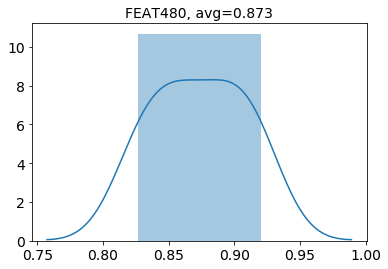

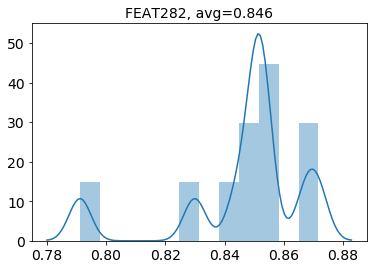

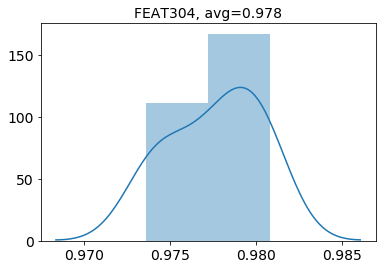

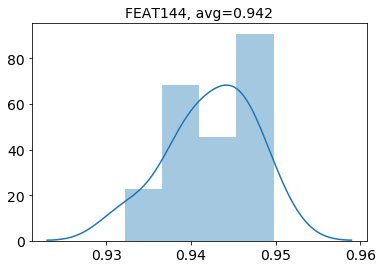

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

for k in configs:
    res_list = zs_res[k]
    ax =sns.distplot(res_list)
    ax.set_title("%s, avg=%.3f"%(configs[k]['feat_name'], np.mean(res_list)))
    plt.show()

# Reload single-run AMBER and re-train for full epochs

In [10]:
from datetime import datetime
import os

par_wd = "/mnt/home/zzhang/workspace/src/AMBER-ZeroShot/examples/outputs/new_20200919/test_feats/single_run/"
sr_hist = {}
for k in configs:
    feat_name = configs[k]['feat_name']
    wd = "%s/%s/" % (par_wd, feat_name)
    train_hist = pd.read_table(os.path.join(wd,"train_history.csv"), header=None, sep=",")
    train_hist.head()
    # each controller step has 5 child networks sampled..
    train_hist['step'] = train_hist[0]//5
    train_hist['auc'] = train_hist[2]
    dt = []
    for i in range(train_hist.shape[0]):
        child_model_fp = os.path.join(wd, "weights", "trial_%i"%train_hist.iloc[i][0])
        timestamp = os.path.getmtime(child_model_fp)
        timestamp = datetime.fromtimestamp(timestamp)
        if i==0:
            starttime = timestamp
        dt.append(timestamp - starttime)

    train_hist['ctime'] = dt
    train_hist = train_hist.loc[train_hist['step']<=60]
    sr_hist[k] = train_hist

In [11]:
delta_time = [sr_hist[k].ctime.tail(1) for k in configs]
print(delta_time)
#sns.distplot(delta_time)

[304   1 days 23:48:00.911253
Name: ctime, dtype: timedelta64[ns], 304   2 days 04:19:56.292139
Name: ctime, dtype: timedelta64[ns], 304   1 days 22:17:35.394065
Name: ctime, dtype: timedelta64[ns], 304   1 days 22:35:13.054455
Name: ctime, dtype: timedelta64[ns]]


In [12]:
sampling_interval = 5
do_retrain = False
n_rep = 10

sr_res = {}
for k in configs:
    np.random.seed(1223)
    train_hist = sr_hist[k]
    single_run_res = {}
    step_time = {}
    arc_seq_cols = np.arange(3, 13, dtype='int')
    steps_to_retrain = np.arange(0, train_hist['step'].max(), sampling_interval)
    #steps_to_retrain = np.concatenate([steps_to_retrain, [train_hist['step'].max()]])
    print(steps_to_retrain)
    for step in steps_to_retrain[1:]:
        #arcs = train_hist.loc[train_hist['step'] == step]
        step_idx = (train_hist['step']<=step) & (train_hist['step']>step-sampling_interval)
        arcs = train_hist.loc[ step_idx ]
        arcs = arcs[arc_seq_cols].to_numpy()
        #orig_rewards = train_hist.loc[train_hist['step'] == step]['auc'].to_numpy()
        orig_rewards = train_hist.loc[step_idx]['auc'].to_numpy()
        orig_runtime = train_hist.loc[step_idx]['ctime'].to_numpy()
        samp_idx = np.random.choice(arcs.shape[0], n_rep, replace=(n_rep>arcs.shape[0]))
        arcs = arcs[samp_idx]
        orig_rewards = orig_rewards[samp_idx]
        orig_runtime = orig_runtime[samp_idx]

        single_run_res[step] = []
        step_time[step] = []
        for i in range(n_rep):
            if do_retrain:
                reward, _ = manager.get_rewards(trial=global_manager_trial_cnt[k], model_arc=arcs.iloc[i])
                print(reward)
            else:
                reward = orig_rewards[i]
            global_manager_trial_cnt[k] += 1
            single_run_res[step].append(reward)
            step_time[step].append(orig_runtime[i])
            global_manager_record = global_manager_record.append({
                'manager': k, 
                'feat_name': feat_name, 
                'amber': 'sr', 
                'step': step,
                'arc': ','.join([str(a) for a in arcs[i]]),
                'reward': reward
            }, ignore_index=True)

    sr_df = pd.DataFrame([(k,v1, v2) for k in single_run_res for v1, v2 in zip(*[single_run_res[k], step_time[k]])], columns=['step', 'auc', 'time'])
    sr_res[k] = sr_df

[ 0  5 10 15 20 25 30 35 40 45 50 55]
[ 0  5 10 15 20 25 30 35 40 45 50 55]
[ 0  5 10 15 20 25 30 35 40 45 50 55]
[ 0  5 10 15 20 25 30 35 40 45 50 55]


## Merge with single-run AMBER

FEAT480


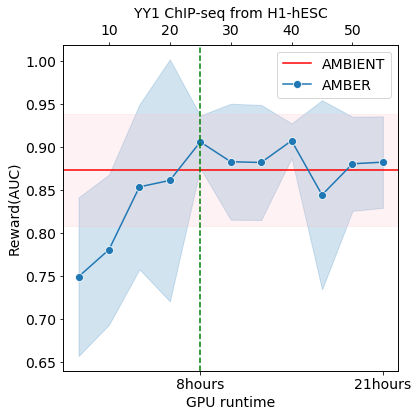

FEAT282


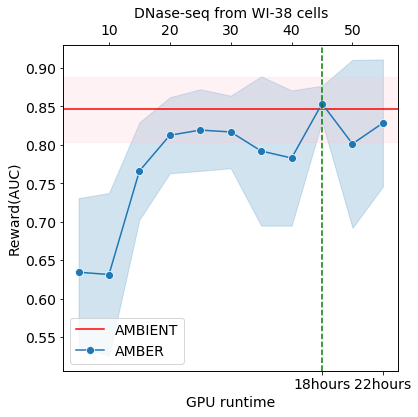

FEAT304


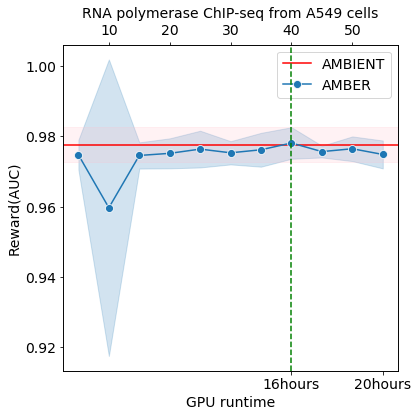

FEAT144


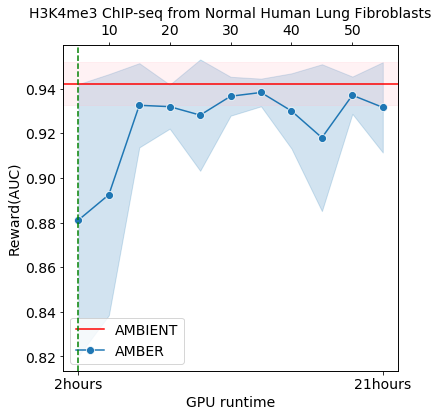

In [13]:
from zs_config import read_metadata

meta = read_metadata()

def convert_timedelta(duration):
    days, seconds = duration.days, duration.seconds
    hours = days * 24 + seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = (seconds % 60)
    return hours, minutes, seconds

title_mapper = {
    "H1-hESC_YY1_None": "YY1 ChIP-seq from H1-hESC",
    "WI-38_DNase_None": "DNase-seq from WI-38 cells",
    "A549_Pol2_None": "RNA polymerase ChIP-seq from A549 cells",
    "NHLF_H3K4me3_None": "H3K4me3 ChIP-seq from Normal Human Lung Fibroblasts"
}

for k in configs:
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax2 = ax.twiny()
    feat_name = configs[k]['feat_name']
    print(feat_name)
    human_readable_name = meta.loc[feat_name]['new_name']
    sr_df = sr_res[k]
    zs_auc = zs_res[k]
    ax.axhspan(np.mean(zs_auc)-2*np.std(zs_auc), np.mean(zs_auc)+2*np.std(zs_auc), alpha=0.2, color='pink')
    ax.axhline(y=np.mean(zs_auc), color='red', label="AMBIENT")
    sns.lineplot(x='step', y='auc', marker='o', ci='sd', label="AMBER", data=sr_df, ax=ax)
    #ax.set_title("Manager%i:%s:%s"%(k,feat_name, human_readable_name))
    ax.set_title("%s"%( title_mapper[human_readable_name]))
    ax.set_xlabel("AMBER step")
    ax.set_ylabel("Reward(AUC)")
    #ax.set_ylim(0.5, 1)

    # add run-time as second x-axis
    ax2.set_xlim(ax.get_xlim())
    sr_auc_mean = sr_df.groupby("step").mean()
    new_tick_locations = [(sr_auc_mean-np.mean(zs_auc)>0).idxmax().tolist()[0], sr_df['step'].max()]
    #print(new_tick_locations)
    #ax2.set_xticks(new_tick_locations)
    ax.set_xticks(new_tick_locations)
    #ax2.set_xticklabels(sr_df.loc[new_tick_locations, "time"].apply(
    #    lambda x: "%shours"%convert_timedelta(x)[0]))
    ax.set_xticklabels(sr_df.loc[new_tick_locations, "time"].apply(lambda x: "%shours"%convert_timedelta(x)[0]))

    #ax2.set_xlabel("GPU runtime")
    ax.set_xlabel("GPU runtime")
    ax2.axvline(x=new_tick_locations[0], linestyle='--', color='green')
    
    plt.savefig("./outputs/new_20200919/ZS_SR_comparison.%s.pdf"%human_readable_name)    
    plt.show()

In [14]:
global_manager_record.to_csv("outputs/new_20200919/ZS_SR_comparison.tsv", sep="\t")